In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


import scipy.stats as stats 
from scipy.stats import chi2_contingency, boxcox

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm 

In [7]:
df = pd.read_csv('Maternal-risk-analized.csv')

# PREDICCIÓN DE RIESGO MATERNAL CON ALGORITMO RANDOM FOREST 

In [10]:
class_weight = {0:0.2, 1:0.5, 2:0.3}

In [12]:
x = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

In [14]:
#Separamos datos entre muestra de entrenamiento y muestra de test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101, stratify=y)

Se basa en los modelos de árboles de decisión- 

Construye árboles de decisión independientes cada uno entrenado con un subconjunto del dataset, 
los subconjuntos se crean seleccionado de forma aleatoria muestras del dataset. y cada nodo del árbol tiene un subconjunto de caraxterísticas
seleccionadas aleatoriamente. 

De forma que para clasificar una muestra nuueva, cada árbol hace una predicción, el Random Forest combina las predicciones 
mediante voto mayoritario. 

Configuración de nuestro algoritmo:
<ol>
    <li>n_estimators: nº de árboles en el bosque, probamos con 100, 300, 500.</li>
    <li>criterion:el creiterio  que usamos para medir la calidad de divisiones de los árboles es índice de gini y
    entropía de información</li>
    <li>Profundidad mázima de los árboles: 15, 30, 50.</li>
    <li>min_samples_leaf: nº mínimo de muestras requeridas por hoja: 3, 5, 7.</li>
</ol>

Estos son los datos que probaremos a priori, sin embargo, como hemos hecho antes, 
vamos a aaplicar la estrategia de validación cruzada para buscar la mejor combinación posible. Para esta solución, 
usaremos GridSearchCV, es una tecnica para buscar hiperparámetros usando combinación cruzada para las opciones que hayamos declarado anteriormente. 

In [19]:
classifier = RandomForestClassifier(class_weight=class_weight)

#Definimos hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'max_depth': [15, 30, 50, 75, 100, 150],
    'min_samples_split':[2,5,10,15,20],
    'min_samples_leaf': [3, 5, 7, 10,15], 
    'max_features': ['sqrt', 'log2', None, 0.6, 3], 
    'bootstrap': [True, False]
    }

#creamos objeto GridSearchCV
#Realizamos validación cruzada de 5 particiones (cv = 5)
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print('Mejores parámetros a usar:', grid_search.best_params_)
print('Mejor precisión:', grid_search.best_score_)

#Identificación del mejor modelo
best_forest = grid_search.best_estimator_

C:\Users\virginia.anton\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Mejores parámetros a usar: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 75, 'max_features': 0.6, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 50}
Mejor precisión: 0.6900297619047618


In [35]:
forest_pred = grid_search.predict(X_test)

In [12]:
# Crear un nuevo modelo Random Forest con los mejores parámetros
final_model = RandomForestClassifier(
    n_estimators=50,
    criterion='entropy',
    max_depth=75,
    min_samples_split=20,
    min_samples_leaf=5,
    max_features=0.6,
    bootstrap=True,
    random_state=42  # Para reproducibilidad
)

# Entrenar el modelo con los datos de entrenamiento
final_model.fit(X_train, y_train)

# Hacer predicciones con el modelo final
y_pred = final_model.predict(X_test)

# Evaluar el modelo
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.99      0.84        70
           1       1.00      0.12      0.22        32
           2       0.81      0.88      0.85        34

    accuracy                           0.76       136
   macro avg       0.85      0.66      0.63       136
weighted avg       0.81      0.76      0.69       136



In [14]:
from sklearn.model_selection import cross_val_score

# Validación cruzada
scores = cross_val_score(final_model, X_train, y_train, cv=5)

print("Cross-validation scores:", scores)
print(f"Mean CV Accuracy: {scores.mean():.2f}")

Cross-validation scores: [0.703125   0.68253968 0.66666667 0.68253968 0.73015873]
Mean CV Accuracy: 0.69


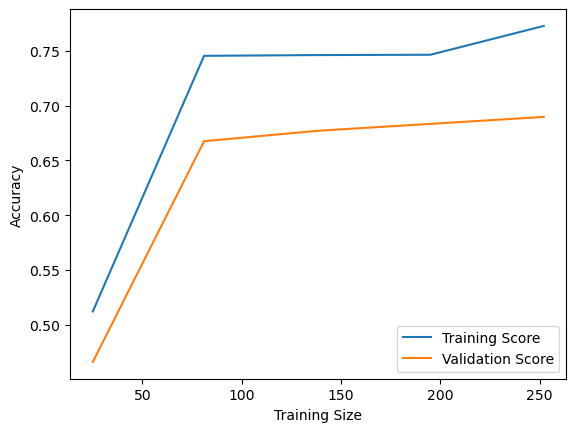

In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(final_model, X_train, y_train, cv=5)

# Calcular medias
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Graficar
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [18]:
import joblib
joblib.dump(final_model, 'maternal-risk-RF-model.pkl')
print("Modelo guardado como 'maternal-risk-RF-model.pkl'")

Modelo guardado como 'maternal-risk-RF-model.pkl'


## PRUEBA CON DATOS DEL WEARABLE CREADOS CON GRETEL.IA

In [19]:
wearabledf= pd.read_csv('wearable-simulation-with-common-users.csv')

In [17]:
import joblib

# Cargar el modelo guardado
model_path = 'maternal-risk-RF-model.pkl'  # Cambia a la ruta donde esté el archivo si es necesario
loaded_model = joblib.load(model_path)
print("Modelo cargado exitosamente.")

Modelo cargado exitosamente.


In [21]:
wearabledf.head()

,user_id,Age,timestamp,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,day,month&year,date,week,trimester
0,user_0000,32,2024-06-16 02:45:05,89.0,134.0,8.26,98.696800,100.0,2024-06-16,2024-06,2024-06-16,3,First
1,user_0000,32,2024-06-16 10:45:05,87.0,130.0,8.33,98.711909,108.0,2024-06-16,2024-06,2024-06-16,3,First
2,user_0000,32,2024-06-16 18:45:05,87.0,130.0,8.33,98.711909,108.0,2024-06-16,2024-06,2024-06-16,3,First
3,user_0000,31,2024-06-18 07:37:54,87.0,133.0,8.86,98.843603,121.0,2024-06-18,2024-06,2024-06-18,3,First
4,user_0000,31,2024-06-18 15:37:54,86.0,131.0,7.99,98.870108,102.0,2024-06-18,2024-06,2024-06-18,3,First


In [23]:
wearabledf['week'].nunique()

20

In [25]:
#Cargar el modelo desde el archivo
rf_model = joblib.load('maternal-risk-RF-model.pkl')

In [27]:
features = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
X = wearabledf[features]
wearabledf['Predicted_Risk'] = rf_model.predict(X)
print(wearabledf['Predicted_Risk'].head())


0    2
1    2
2    2
3    2
4    2
Name: Predicted_Risk, dtype: int64


In [29]:
wearabledf.head()

,user_id,Age,timestamp,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,day,month&year,date,week,trimester,Predicted_Risk
0,user_0000,32,2024-06-16 02:45:05,89.0,134.0,8.26,98.696800,100.0,2024-06-16,2024-06,2024-06-16,3,First,2
1,user_0000,32,2024-06-16 10:45:05,87.0,130.0,8.33,98.711909,108.0,2024-06-16,2024-06,2024-06-16,3,First,2
2,user_0000,32,2024-06-16 18:45:05,87.0,130.0,8.33,98.711909,108.0,2024-06-16,2024-06,2024-06-16,3,First,2
3,user_0000,31,2024-06-18 07:37:54,87.0,133.0,8.86,98.843603,121.0,2024-06-18,2024-06,2024-06-18,3,First,2
4,user_0000,31,2024-06-18 15:37:54,86.0,131.0,7.99,98.870108,102.0,2024-06-18,2024-06,2024-06-18,3,First,2


In [31]:
wearabledf.describe()

,Age,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,week,Predicted_Risk
count,4233.000000,4233.000000,4233.000000,4233.000000,4233.000000,4233.000000,4233.000000,4233.000000
mean,31.482636,72.641632,117.300712,6.683021,98.736781,104.155091,8.916135,0.717931
std,2.995072,10.364789,10.183896,1.910891,0.610832,6.736692,6.706323,0.952711
min,19.000000,61.000000,101.000000,3.375000,95.800000,68.000000,0.000000,0.000000
25%,32.000000,65.078125,110.070312,5.575000,98.506107,100.000000,4.000000,0.000000
50%,32.000000,65.101562,110.101562,5.575000,98.711909,104.500000,4.000000,0.000000
75%,32.000000,86.000000,130.000000,8.320000,98.900000,107.000000,17.000000,2.000000
max,45.000000,99.000000,149.000000,13.000000,106.500000,159.000000,26.000000,2.000000


In [35]:
wearabledf.to_csv('wearable-maternal-risk-predictions.csv', index=False)

## Distribución de predicciones por nivel de riesgo

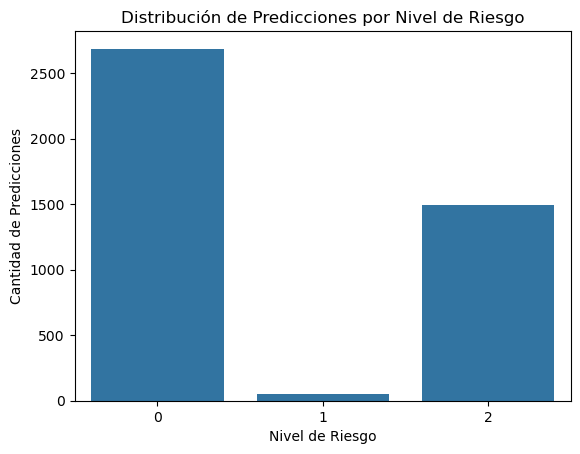

In [37]:

sns.countplot(data=wearabledf, x='Predicted_Risk', order=[0, 1, 2])
plt.title('Distribución de Predicciones por Nivel de Riesgo')
plt.xlabel('Nivel de Riesgo')
plt.ylabel('Cantidad de Predicciones')
plt.show()

## EVOLUCIÓN DEL RIESGO A LO LARGO DEL TIEMPO

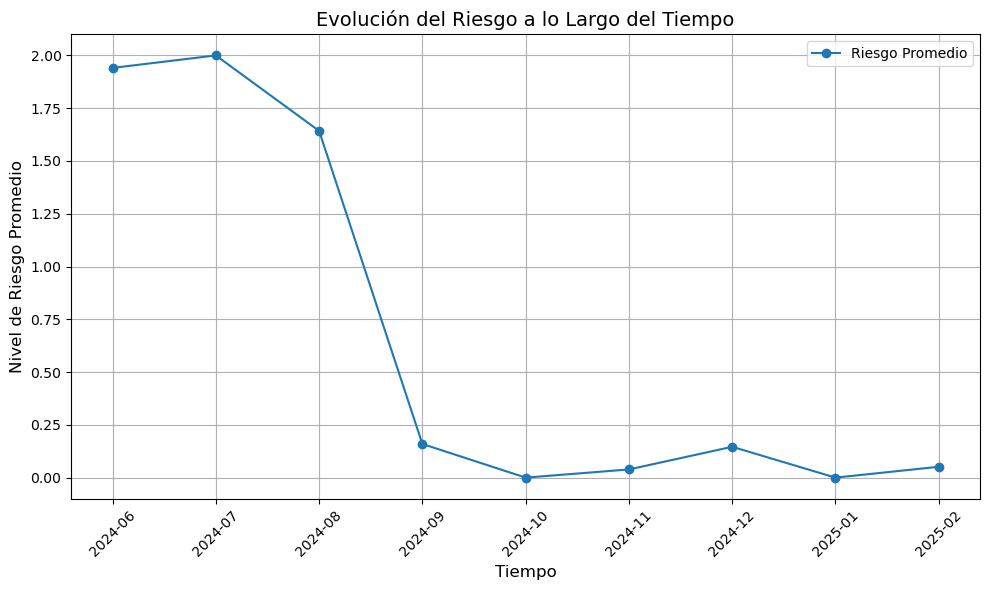

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
wearabledf['timestamp'] = pd.to_datetime(wearabledf['timestamp'])

#agrupamos por mes y calculamos el riesgo promedio
risk_over_time = wearabledf.groupby('month&year')['Predicted_Risk'].mean()
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(risk_over_time.index, risk_over_time.values, marker='o', linestyle='-', label='Riesgo Promedio')
plt.title('Evolución del Riesgo a lo Largo del Tiempo', fontsize=14)
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('Nivel de Riesgo Promedio', fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Como es de esperar, el primer trimestre es crítico debido a los rápidos cambios hormonales y fisiológicos, y es de sentido que sea el que mayor riesgo presente. 

In [211]:
wearabledf.head()

,user_id,Age,timestamp,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,day,month&year,date,week,trimester,Predicted_Risk
0,user_0000,32,2024-06-16 02:45:05,89.0,134.0,8.26,98.696800,100.0,2024-06-16,2024-06,2024-06-16,3,First,2
1,user_0000,32,2024-06-16 10:45:05,87.0,130.0,8.33,98.711909,108.0,2024-06-16,2024-06,2024-06-16,3,First,2
2,user_0000,32,2024-06-16 18:45:05,87.0,130.0,8.33,98.711909,108.0,2024-06-16,2024-06,2024-06-16,3,First,2
3,user_0000,31,2024-06-18 07:37:54,87.0,133.0,8.86,98.843603,121.0,2024-06-18,2024-06,2024-06-18,3,First,2
4,user_0000,31,2024-06-18 15:37:54,86.0,131.0,7.99,98.870108,102.0,2024-06-18,2024-06,2024-06-18,3,First,2


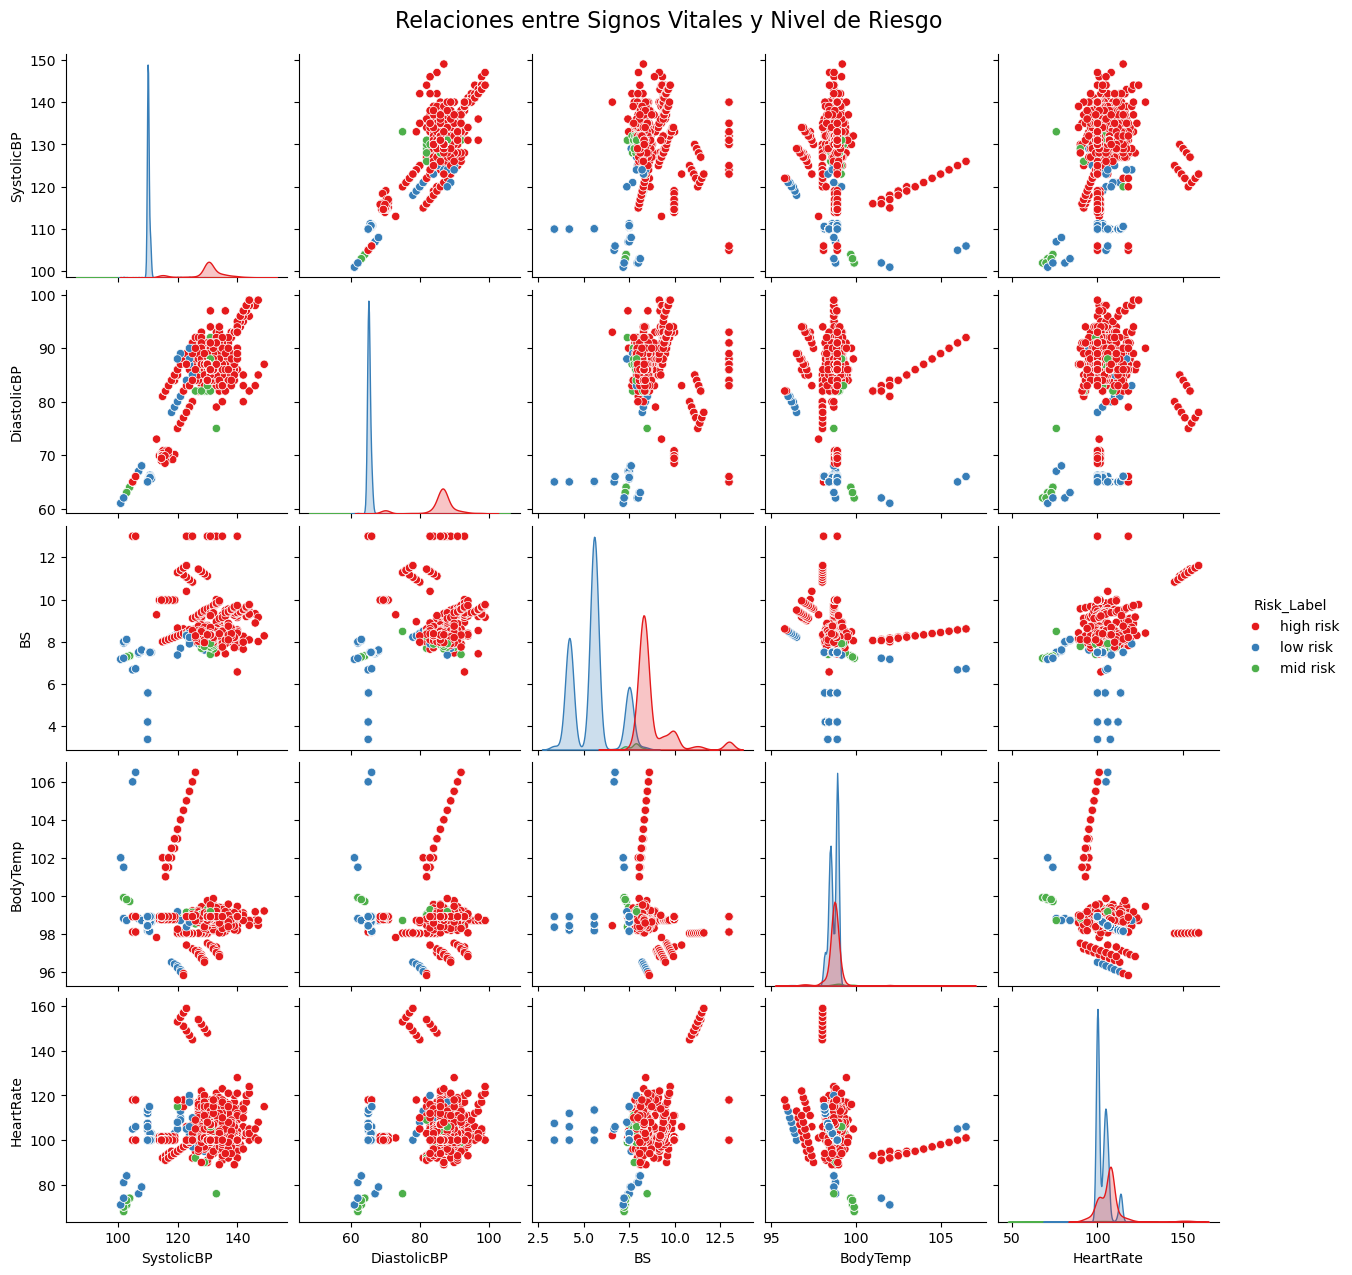

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapear las categorías numéricas a etiquetas
risk_mapping = {0: 'low risk', 1: 'mid risk', 2: 'high risk'}
wearabledf['Risk_Label'] = wearabledf['Predicted_Risk'].map(risk_mapping)
#signos vitales a analizar
vital_signs = ['SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'Risk_Label']

pairplot = sns.pairplot(
    data=wearabledf[vital_signs], 
    hue='Risk_Label', 
    palette='Set1', 
    diag_kind='kde', 
    height=2.5
    
)
pairplot.fig.suptitle("Relaciones entre Signos Vitales y Nivel de Riesgo", y=1.02, fontsize=16)
plt.show()

Podemo observar que efectivamente, valores altos en presión arterial y de azúcar en sangre corresponde a mayor riesgo, que junto con el grafico de arriba, parece que las mujeres situadas en el primer trimestre tienen mayor riesgo, 
y es que es en esa época donde todos los signos vitales tienden a ser máximos y con gran variabilidad, debido a los cambios hormonales. 

Parece que la variable de temperatura corporal es menos influyente, porque esán todas las etiquetas distribuuidas en el mismo rango. Variables como SystolicBP y DiastolicBP parecen tener una variación más amplia, lo que podría aumentar su importancia en el modelo.

In [210]:
def calculate_trimester(week):
    if 1 <= week <= 13:
        return 'Trimester 1'
    elif 14 <= week <=26:
        return 'Trimester 2'
    elif 27 <= week <=40:
        return 'Trimester 3'
    else: 
        return 'Unknown'
    
    

In [214]:
# Aplicar la función en la columna de semanas
wearabledf['Trimester'] = wearabledf['week'].apply(calculate_trimester)

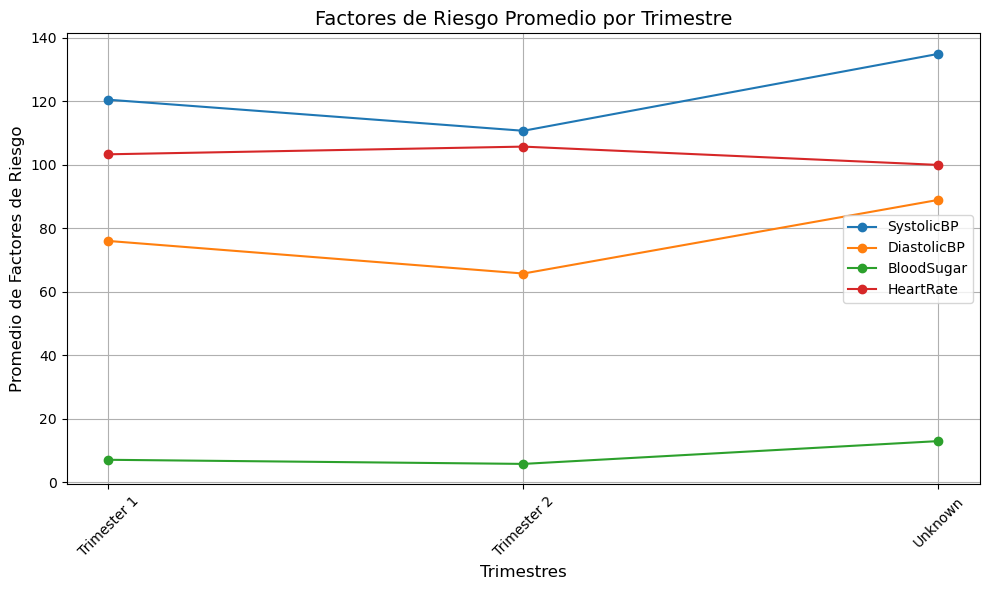

In [218]:
distribution = wearabledf.groupby('Trimester').size() #Distribucion de datos por trimestre

#Analizamos factores específicos que contribuyen al riesgo
risk_factors_by_quarter= wearabledf.groupby('Trimester')[['SystolicBP', 'DiastolicBP', 'BS', 'HeartRate']].mean() 

plt.figure(figsize=(10,6))

plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['SystolicBP'], marker = 'o', linestyle='-', label = 'SystolicBP')
plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['DiastolicBP'], marker = 'o', linestyle='-', label = 'DiastolicBP')
plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['BS'], marker = 'o', linestyle='-', label = 'BloodSugar')
plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['HeartRate'], marker = 'o', linestyle='-', label = 'HeartRate')

plt.title('Factores de Riesgo Promedio por Trimestre', fontsize=14)
plt.xlabel('Trimestres', fontsize=12)
plt.ylabel('Promedio de Factores de Riesgo', fontsize=12)
plt.grid(True)

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

La presión arterial, sigue la tendencia que cabe esperar, al principio tiende a ser baja y llega al punto más bajo en el segundo trimestre, en el tercero sube y recuepra el valor normal e incluso lo sobrepasa. 

La frecuencia cardíaca en cambio, debería ir siempre en aumento por el acople del latido de corazón del feto, llegando a su máximo valor en el tercer trimestre, algo que no percibimos en la presente gráfica. 

La curva de la glucosa es de esperar, ya que según pasan los trimestres hay mayor resistencia a insulina y suben los niveles de glucosa. 


## PRUEBA CON LOS DATOS DE CONSULTA

In [39]:
encounter= pd.read_csv('encounter-simulation-with-common-users.csv')

In [41]:
encounter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8363 entries, 0 to 8362
Data columns (total 28 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Unnamed: 0                                          8363 non-null   int64  
 1   user_id                                             8363 non-null   object 
 2   UNITS                                               8363 non-null   object 
 3   DATE                                                8363 non-null   object 
 4   BIRTHDATE                                           8363 non-null   object 
 5   GENDER                                              8363 non-null   object 
 6   RACE                                                8363 non-null   object 
 7   ETHNICITY                                           8363 non-null   object 
 8   Age                                                 8363 non-null   int64  
 9

In [43]:
encounter.head()

,Unnamed: 0,user_id,UNITS,DATE,BIRTHDATE,GENDER,RACE,ETHNICITY,Age,HAS_DIABETES,...,BS,Glucose [Mass/volume] in Serum or Plasma,Glucose [Mass/volume] in Urine by Test strip,Glucose [Presence] in Urine by Test strip,HeartRate,SystolicBP,common_id,wearable_user_id,visit_number,Adjusted_DATE
0,17523,006a3718-02e0-4eee-deb2-27735709da2d,cm,2015-01-31 19:16:48+00:00,1982-11-13,F,white,nonhispanic,32,1,...,4.93395,91.1,0.9,0.0,93.0,90.0,user_151,user_0060,1,2024-06-26
1,17524,006a3718-02e0-4eee-deb2-27735709da2d,kg,2015-01-31 19:16:48+00:00,1982-11-13,F,white,nonhispanic,32,1,...,4.93395,91.1,0.9,0.0,93.0,90.0,user_151,user_0060,2,2024-06-26
2,17525,006a3718-02e0-4eee-deb2-27735709da2d,kg/m2,2015-01-31 19:16:48+00:00,1982-11-13,F,white,nonhispanic,32,1,...,4.93395,91.1,0.9,0.0,93.0,90.0,user_151,user_0060,3,2024-06-26
3,17526,006a3718-02e0-4eee-deb2-27735709da2d,mm[Hg],2015-01-31 19:16:48+00:00,1982-11-13,F,white,nonhispanic,32,1,...,4.93395,91.1,0.9,0.0,93.0,90.0,user_151,user_0060,4,2024-06-26
4,17527,006a3718-02e0-4eee-deb2-27735709da2d,mm[Hg],2015-01-31 19:16:48+00:00,1982-11-13,F,white,nonhispanic,32,1,...,4.93395,91.1,0.9,0.0,93.0,90.0,user_151,user_0060,5,2024-06-26


Vamos a quedarnos con las columnas que nos interesan y a cambiarlas el nombre para que coincidan con los nombres como se entrenó al modelo. 

In [46]:
colsToKeep = {
    'Age':'Age', 
    'SystolicBP': 'SystolicBP', 
    'DiastolicBP':'DiastolicBP', 
    'BS':'BS', 
    'HeartRate':'HeartRate', 
    'Adjusted_DATE': 'day',
    'visit_number': 'visit_number', 
    'user_id':'user_id'
}
encounter = encounter[list(colsToKeep.keys())].rename(columns=colsToKeep)

In [48]:
encounter['BodyTemp'] = wearabledf['BodyTemp']
encounter.head()

,Age,SystolicBP,DiastolicBP,BS,HeartRate,day,visit_number,user_id,BodyTemp
0,32,90.0,72.0,4.93395,93.0,2024-06-26,1,006a3718-02e0-4eee-deb2-27735709da2d,98.696800
1,32,90.0,72.0,4.93395,93.0,2024-06-26,2,006a3718-02e0-4eee-deb2-27735709da2d,98.711909
2,32,90.0,72.0,4.93395,93.0,2024-06-26,3,006a3718-02e0-4eee-deb2-27735709da2d,98.711909
3,32,90.0,72.0,4.93395,93.0,2024-06-26,4,006a3718-02e0-4eee-deb2-27735709da2d,98.843603
4,32,90.0,72.0,4.93395,93.0,2024-06-26,5,006a3718-02e0-4eee-deb2-27735709da2d,98.870108


In [50]:
features = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
X = encounter[features]
encounter['Predicted_Risk'] = rf_model.predict(X)
print(encounter['Predicted_Risk'].head())


0    0
1    0
2    0
3    0
4    0
Name: Predicted_Risk, dtype: int64


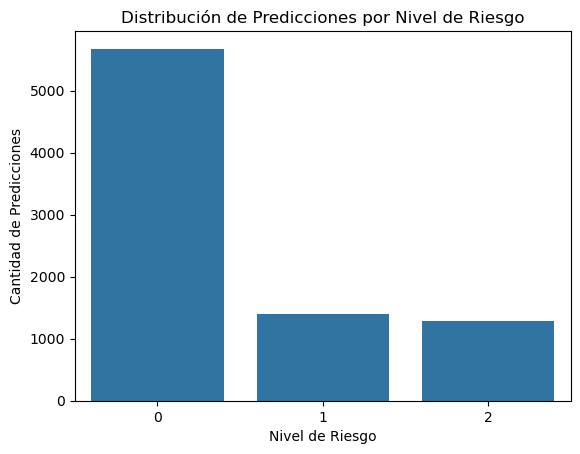

In [52]:
sns.countplot(data=encounter, x='Predicted_Risk', order=[0, 1, 2])
plt.title('Distribución de Predicciones por Nivel de Riesgo')
plt.xlabel('Nivel de Riesgo')
plt.ylabel('Cantidad de Predicciones')
plt.show()

**Añadimos columna de visitas**


In [55]:
encounter['visit_number'] = encounter.groupby('day').cumcount() + 1


C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_18012\1155328229.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encounter_filtered['Trimester'] = encounter_filtered['day'].dt.to_period('Q') #extraemos trimestre, aquí hay 4 trimestes: q1, q2, q3 y q4.


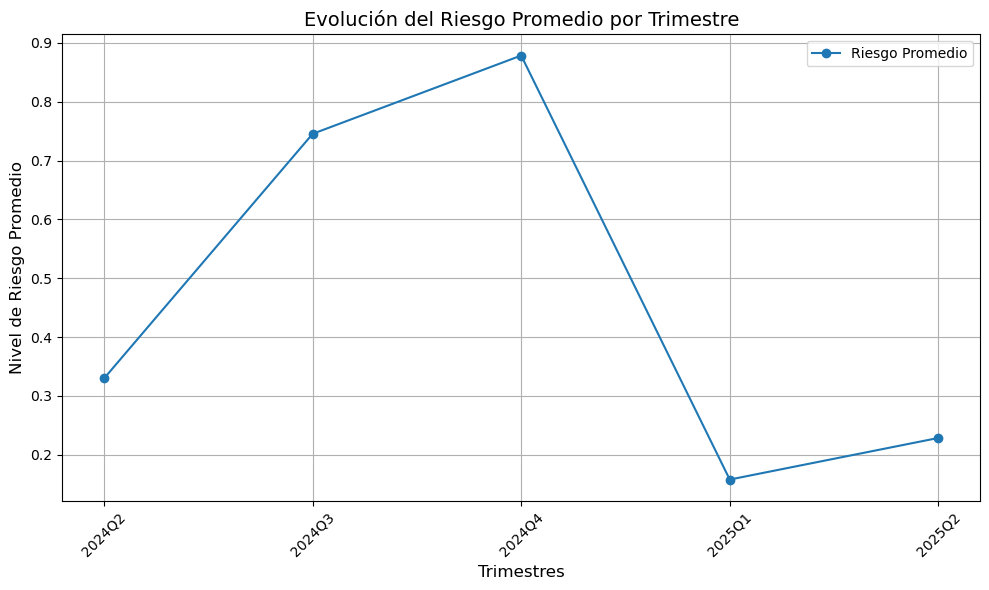

In [57]:
# Convert 'Adjusted_DATE' to datetime format if not already
encounter['day'] = pd.to_datetime(encounter['day'])
# Definir las fechas de inicio y fin como datetime
start_date = pd.to_datetime('2024-06-02')
end_date = pd.to_datetime('2025-04-30')

# Filtrar las filas entre las fechas especificadas
encounter_filtered = encounter[(encounter['day'] >= start_date) & (encounter['day'] <= end_date)]

# Create a column for the quarter
encounter_filtered['Trimester'] = encounter_filtered['day'].dt.to_period('Q') #extraemos trimestre, aquí hay 4 trimestes: q1, q2, q3 y q4. 

# Group by 'Quarter' and calculate the average risk
quarterly_risk = encounter_filtered.groupby('Trimester')['Predicted_Risk'].mean()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(quarterly_risk.index.astype(str), quarterly_risk.values, marker='o', linestyle='-', label='Riesgo Promedio')
plt.title('Evolución del Riesgo Promedio por Trimestre', fontsize=14)
plt.xlabel('Trimestres', fontsize=12)
plt.ylabel('Nivel de Riesgo Promedio', fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Como tenemos más valores discretos de días de visista, se promedia el riesgo por trimestres para poder visualizar cómo evoluciona al riesgo a lo largo de los trimestres.
Conclusiones:

El aumento del riesgo promedio en los trimestres 2 y 3 puede estar influenciado por una combinación de factores fisiológicos, estacionales y relacionados con la composiicón de la muestra.

In [60]:
encounter.head()

,Age,SystolicBP,DiastolicBP,BS,HeartRate,day,visit_number,user_id,BodyTemp,Predicted_Risk
0,32,90.0,72.0,4.93395,93.0,2024-06-26,1,006a3718-02e0-4eee-deb2-27735709da2d,98.696800,0
1,32,90.0,72.0,4.93395,93.0,2024-06-26,2,006a3718-02e0-4eee-deb2-27735709da2d,98.711909,0
2,32,90.0,72.0,4.93395,93.0,2024-06-26,3,006a3718-02e0-4eee-deb2-27735709da2d,98.711909,0
3,32,90.0,72.0,4.93395,93.0,2024-06-26,4,006a3718-02e0-4eee-deb2-27735709da2d,98.843603,0
4,32,90.0,72.0,4.93395,93.0,2024-06-26,5,006a3718-02e0-4eee-deb2-27735709da2d,98.870108,0


## FACTORES DE RIESGO DURANTE EL TRIMESTRE

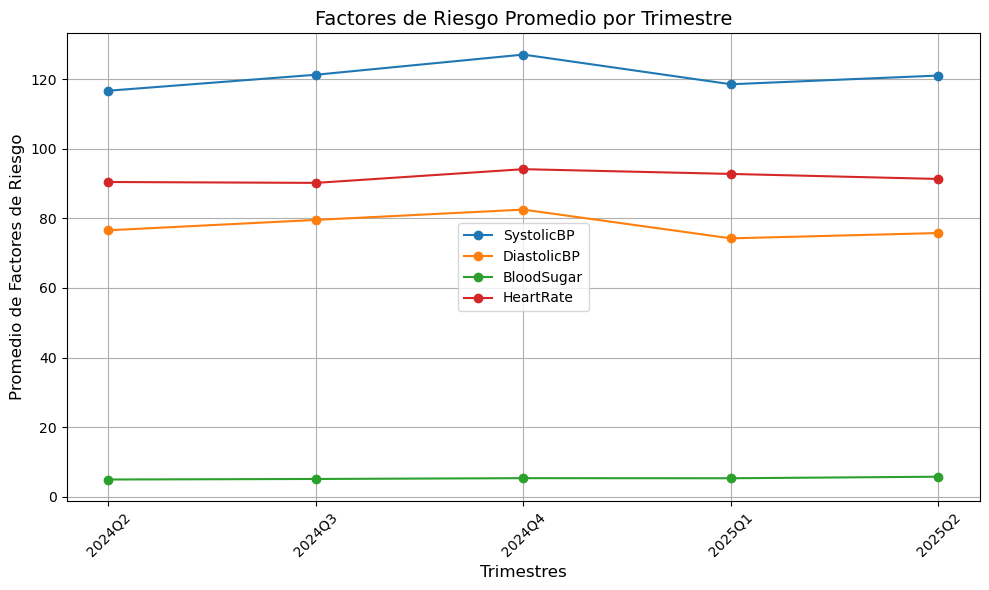

In [63]:
distribution = encounter_filtered.groupby('Trimester').size() #Distribucion de datos por trimestre

#Analizamos factores específicos que contribuyen al riesgo
risk_factors_by_quarter= encounter_filtered.groupby('Trimester')[['SystolicBP', 'DiastolicBP', 'BS', 'HeartRate']].mean() 

plt.figure(figsize=(10,6))

plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['SystolicBP'], marker = 'o', linestyle='-', label = 'SystolicBP')
plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['DiastolicBP'], marker = 'o', linestyle='-', label = 'DiastolicBP')
plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['BS'], marker = 'o', linestyle='-', label = 'BloodSugar')
plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['HeartRate'], marker = 'o', linestyle='-', label = 'HeartRate')

plt.title('Factores de Riesgo Promedio por Trimestre', fontsize=14)
plt.xlabel('Trimestres', fontsize=12)
plt.ylabel('Promedio de Factores de Riesgo', fontsize=12)
plt.grid(True)

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
encounter.to_csv('encounter-maternal-risk-predictions.csv', index=False)

Observaciones:
<ol>
    <li>SystolicBP y DiastolicBP: en el primer trimestre tiende a disminuir por el cambio hormonal, y en los siguientes trimestres va en aumento. Como podemos observar, en el tercer trimestre llega a su máximo pico, como cabría esperar, aunque debería ser el trimestre dos el punto más bajo.</li>
    <li> BloodSugar: se puede percibir un pequeño incremento en la resistencia a la glucosa, cambio que también cabe epserar y más si hay pacientes que padecen GDM.</li>
    <li>HeartRate: ocurre como en la presion arterial, según va avanzando el embarazo, la frecuecia cardíaca es cada vez mayor (porque se adapta con el latido del feto), hasta llegar a un máximo en el tercer trimestre,una vez dado a luz se vuuelve a los valores iniciales. </li>
</ol>

# CONCLUSIONES GENERALES

<p>Variaciones entre trimestres</p>
<ol>
    <li>Wearable: La variación entre trimestre es menor y los datos parecen más uniformes, podría deberse a un mayor número de mediciones promedidas, lo que reduce el impacto de los valores extremos</li>
    <li>Consulta médica: las mediciones muestran tendencias más claras, con picos y caídas significativas, como el aumento en el tercer trimestre (Q4 2024) en la presión arterial y glucosa. Esto es un reflejo del crecimiento fetal, que alcanza su máximo en el tercer trmiestre y mayor precisión de los equipos médicos.</li>
</ol>
<p>Causas de las diferencias:</p>
<ol>
    <li>Precisión del dispositivo:Wearable mide en situaciones no controladas y es un dispositvo menos preciso y en cambio, los médicos usan equipos calibrados para obtener valores más exactos y hacen las mediciones en conddiciones controladas (en reposo). </li>
    <li> La frecuencia de medición del wearable es mayor, por lo que los datos están más suavizados, en cambio en las consultas tomamn menos mediciones, pero son representativas dle etsado clínico del paciente.</li>
</ol>